In [1]:
import pandas as pd
import plotnine as p9
from datetime import datetime
import glob
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# user definined functions

# custom convert date to match the garmin reported data
def convert_date(x):
    return datetime.strptime(x['date'], "%b %d, %Y %I:%M:%S %p")

# extracts daily stress
def explode_daily_stress(x):
    ad = dict(x)
    al = ad['aggregatorList'][0]['averageStressLevel']
    return al

# extracts the awake stress score
def explode_daily_awake_stress(x):
    ad = dict(x)
    al = ad['aggregatorList'][1]['averageStressLevel']
    return al



In [3]:
# read in our data 

# get the 2021 sleep files
sleep_files = []
sleep_df = pd.DataFrame()
for file in glob.glob("../data/f4617e72-eb4d-4f9d-8aec-8d965e6f651c_1/DI_CONNECT/DI-Connect-Wellness/*sleepData.json"):
    if '2021' in file:
        temp_df = pd.read_json(file)
        sleep_df = sleep_df.append(temp_df)

# get the 2021 uds files
uds_files = []
uds_df = pd.DataFrame()
for file in glob.glob("../data/f4617e72-eb4d-4f9d-8aec-8d965e6f651c_1/DI_CONNECT/DI-Connect-User/UDSFile*.json"):
    if '2021' in file: 
        temp_df = pd.read_json(file)
        uds_df = uds_df.append(temp_df)
    
del temp_df
sleep_df.head(2)
uds_df.head(2)

,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,lowestRespiration,highestRespiration,retro,awakeCount,avgSleepStress,sleepScores,userNote
0,2020-10-16T03:20:00.0,2020-10-16T13:07:00.0,2020-10-16,ENHANCED_CONFIRMED,0.0,18720.0,15900.0,600.0,0.0,14.0,9.0,18.0,False,NaN,NaN,NaN,NaN
1,2020-10-17T05:15:00.0,2020-10-17T12:30:00.0,2020-10-17,ENHANCED_CONFIRMED,2940.0,13320.0,9720.0,120.0,0.0,14.0,12.0,17.0,False,NaN,NaN,NaN,NaN


,userProfilePK,calendarDate,uuid,durationInMilliseconds,rulePk,totalKilocalories,activeKilocalories,bmrKilocalories,wellnessKilocalories,remainingKilocalories,...,version,averageMonitoringEnvironmentAltitude,respiration,hydration,burnedKilocalories,isDailyTotalFromEpochData,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal
0,5993977,"{'date': 'Oct 16, 2020 12:00:00 AM'}",db3b261392cf475684e55f1f0b324fcc,86400000,2.0,2220,64,2156,2220,2220,...,1,43,"{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5993977,"{'date': 'Oct 17, 2020 12:00:00 AM'}",2ea77c30a5134f2b8df599089b973b49,86400000,2.0,3395,1239,2156,3395,3395,...,75240002,14,"{'userProfilePK': 5993977, 'calendarDate': {'d...","{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# drop dates without sleep score
sleep_df.shape
sleep_df = sleep_df.dropna(axis=0, subset=['sleepScores'])
sleep_df.shape

(450, 17)

(237, 17)

In [5]:

#sleep_df = pd.read_json('../data/f4617e72-eb4d-4f9d-8aec-8d965e6f651c_1/DI_CONNECT/DI-Connect-Wellness/2021-11-20_2022-02-28_5993977_sleepData.json')
#uds_df = pd.read_json('../data/f4617e72-eb4d-4f9d-8aec-8d965e6f651c_1/DI_CONNECT/DI-Connect-User/UDSFile_2021-11-20_2022-02-28.json')

# explode the sleep scores dictionarys
sleep_scores_temp = pd.json_normalize(sleep_df.sleepScores)
# explode the all day stress 
uds_df['AVG_DAILY_STRESS_DERIVED'] = uds_df.allDayStress.apply(lambda x: explode_daily_stress(x))
uds_df['AVG_AWAKE_STRESS_DERIVED'] = uds_df.allDayStress.apply(lambda x: explode_daily_awake_stress(x))


stress_score_temp = pd.json_normalize(uds_df.allDayStress)
stress_score_temp.head(2)

# assign them back into sleep_df. merge would be faster
for col in sleep_scores_temp.columns:
    sleep_df[col] = sleep_scores_temp[col]

# delete temp df
del sleep_scores_temp

# sleep_df.info()

,userProfilePK,aggregatorList,calendarDate.date
0,5993977,"[{'type': 'TOTAL', 'averageStressLevel': 32, '...","Oct 16, 2020 12:00:00 AM"
1,5993977,"[{'type': 'TOTAL', 'averageStressLevel': 31, '...","Oct 17, 2020 12:00:00 AM"


In [6]:
#sleepdf.shape
#sleepdf.head(2)
#uds_df.shape
#uds_df.head(2)
    
# manipulate the calendar dates so we can merge on them
uds_df.calendarDate = uds_df.calendarDate.apply(lambda x: convert_date(x))
sleep_df.calendarDate = pd.to_datetime(sleep_df.calendarDate)
total_data = pd.merge(sleep_df, uds_df, how='left', on='calendarDate')



In [7]:
# subset to 22W dates
total_data.calendarDate.min()
total_data.calendarDate.max()
is_22W = total_data.calendarDate >= datetime.strptime('2022-01-04', '%Y-%m-%d')
total_data = total_data.loc[is_22W, :].copy()
total_data.calendarDate.min()
total_data.calendarDate.max()

Timestamp('2021-05-31 00:00:00')

Timestamp('2022-02-27 00:00:00')

Timestamp('2022-01-04 00:00:00')

Timestamp('2022-02-27 00:00:00')

In [8]:
total_data.info()
total_data.head()
print('overal score')
total_data.overallScore.describe()
print('deep')
total_data.deepSleepSeconds.describe()
total_data['SLEEP_DURATION_DERIVED'] = total_data.deepSleepSeconds + total_data.lightSleepSeconds + total_data.remSleepSeconds + total_data.awakeSleepSeconds + total_data.unmeasurableSeconds
print('Duration')
total_data.SLEEP_DURATION_DERIVED.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 183 to 236
Data columns (total 86 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   sleepStartTimestampGMT                54 non-null     object        
 1   sleepEndTimestampGMT                  54 non-null     object        
 2   calendarDate                          54 non-null     datetime64[ns]
 3   sleepWindowConfirmationType           54 non-null     object        
 4   deepSleepSeconds                      54 non-null     float64       
 5   lightSleepSeconds                     54 non-null     float64       
 6   remSleepSeconds                       54 non-null     float64       
 7   awakeSleepSeconds                     54 non-null     float64       
 8   unmeasurableSeconds                   54 non-null     float64       
 9   averageRespiration                    54 non-null     float64       
 10  l

,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,...,respiration,hydration,burnedKilocalories,isDailyTotalFromEpochData,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal,AVG_DAILY_STRESS_DERIVED,AVG_AWAKE_STRESS_DERIVED
183,2022-01-04T04:32:00.0,2022-01-04T12:46:00.0,2022-01-04,ENHANCED_CONFIRMED_FINAL,8100.0,14640.0,5880.0,1020.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...","{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,37.0,56.0
184,2022-01-05T04:37:00.0,2022-01-05T11:24:00.0,2022-01-05,ENHANCED_CONFIRMED_FINAL,7200.0,11280.0,5940.0,0.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...","{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,37.0,49.0
185,2022-01-06T04:57:00.0,2022-01-06T13:30:00.0,2022-01-06,ENHANCED_CONFIRMED_FINAL,5820.0,17580.0,7260.0,120.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...","{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,29.0,43.0
186,2022-01-07T05:04:00.0,2022-01-07T12:22:00.0,2022-01-07,ENHANCED_CONFIRMED_FINAL,2940.0,18240.0,4680.0,420.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...","{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,38.0,53.0
187,2022-01-08T05:39:00.0,2022-01-08T13:00:00.0,2022-01-08,ENHANCED_CONFIRMED_FINAL,6000.0,15660.0,4260.0,540.0,0.0,13.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...","{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,35.0,49.0


overal score


count    54.000000
mean     84.722222
std       9.637616
min      60.000000
25%      81.000000
50%      87.500000
75%      91.000000
max      97.000000
Name: overallScore, dtype: float64

deep


count       54.000000
mean      6596.666667
std       1584.942115
min       2580.000000
25%       5835.000000
50%       6750.000000
75%       7425.000000
max      10140.000000
Name: deepSleepSeconds, dtype: float64

Duration


count       54.000000
mean     28343.333333
std       3107.859179
min      18060.000000
25%      26625.000000
50%      28440.000000
75%      29640.000000
max      35820.000000
Name: SLEEP_DURATION_DERIVED, dtype: float64

In [9]:
total_data.deepSleepSeconds.mean()/total_data.SLEEP_DURATION_DERIVED.mean()
total_data.lightSleepSeconds.mean()/total_data.SLEEP_DURATION_DERIVED.mean()
total_data.remSleepSeconds.mean()/total_data.SLEEP_DURATION_DERIVED.mean()
total_data.awakeSleepSeconds.mean()/total_data.SLEEP_DURATION_DERIVED.mean()
total_data.unmeasurableSeconds.mean()/total_data.SLEEP_DURATION_DERIVED.mean()

0.2327413853933906

0.5439256732917793

0.19593084793602258

0.026226037868987417

0.0011760555098200636

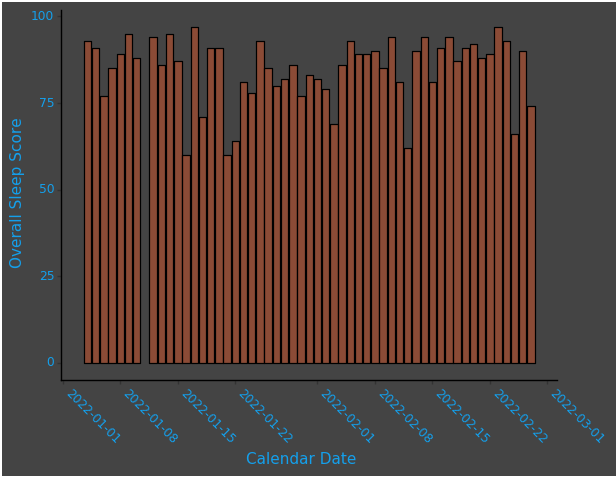

<ggplot: (8779304151953)>

In [10]:
gourdotron_theme = (p9.theme_classic()
                   + p9.theme(axis_text_x = p9.element_text(angle=-45, color='#14a0ec', ha='left'), 
                           axis_text_y = p9.element_text(color='#14a0ec'))
                    + p9.theme(panel_background = p9.element_rect(fill='#444444'), 
                           plot_background = p9.element_rect(fill = "#444444"), 
                           axis_title_x=p9.element_text(color='#14a0ec'), 
                           axis_title_y=p9.element_text(color='#14a0ec')))

sleep_long = (p9.ggplot(data=total_data, mapping=p9.aes(x='calendarDate', y='overallScore'))
                + p9.geom_bar(color='black', stat='identity', fill='#F85621', alpha=0.4)
                + p9.labs(x='Calendar Date', y = 'Overall Sleep Score')
                + gourdotron_theme)
                

sleep_long

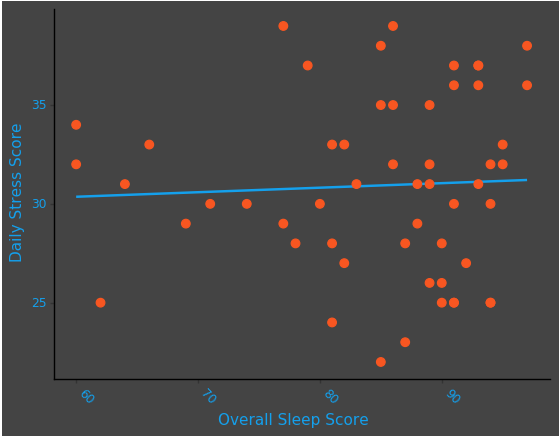

<ggplot: (8779298251261)>

In [11]:
sleep_vs_stress = (p9.ggplot(data=total_data, mapping=p9.aes(x='overallScore', y='AVG_DAILY_STRESS_DERIVED'))
                    + p9.theme_minimal()
                    + p9.geom_smooth(method='lm', se=False, color='#14a0ec')
                    + p9.labs(x='Overall Sleep Score', y='Daily Stress Score')
                    + gourdotron_theme
                    + p9.theme(panel_grid_major=p9.element_line(color='#444444', alpha=.5), panel_grid_minor=p9.element_line(color='#444444', alpha=.5))
                    + p9.geom_point(size=3, color = '#F85621')
                    )

sleep_vs_stress

In [12]:
def convert_date(xle):
    ret = []
    for d in xle:
        yr = d.year
        if d.hour < 8:
            day = str(int(d.day) - 1)
            print(str(d.day) + " - " + str(str(int(d.day) - 1)))
            if d.day == 1: 
                mo = str(int(d.month) - 1)
        else: 
            day = str(int(d.day))
            mo = str(d.month)
    
        ret.append('%s-%s-%s' %(yr, mo.zfill(2), day.zfill(2)))
    return ret

vera_log = pd.read_csv('../data/aloe_vera_log.csv')
vera_log.date = pd.to_datetime(vera_log.date, dayfirst=True)
vera_log['DATEDERIVED'] = pd.to_datetime(convert_date(vera_log.date))
vera_log.DATEDERIVED.nunique()
#vera_log['DATEDERIVED'] = pd.to_datetime(convert_date(vera_log['DATEDERIVED']))
total_data.shape
total_data.head()
vera_log.head(20)
vera_log.shape
total_data_with_percived = pd.merge(total_data, vera_log, how='inner', left_on='calendarDate', right_on='DATEDERIVED')
total_data_with_percived.shape
total_data_with_percived.info()




3 - 2
9 - 8
12 - 11
19 - 18
20 - 19
21 - 20
22 - 21
26 - 25
27 - 26
3 - 2
4 - 3


34

(54, 87)

,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,...,hydration,burnedKilocalories,isDailyTotalFromEpochData,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal,AVG_DAILY_STRESS_DERIVED,AVG_AWAKE_STRESS_DERIVED,SLEEP_DURATION_DERIVED
183,2022-01-04T04:32:00.0,2022-01-04T12:46:00.0,2022-01-04,ENHANCED_CONFIRMED_FINAL,8100.0,14640.0,5880.0,1020.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,37.0,56.0,29640.0
184,2022-01-05T04:37:00.0,2022-01-05T11:24:00.0,2022-01-05,ENHANCED_CONFIRMED_FINAL,7200.0,11280.0,5940.0,0.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,37.0,49.0,24420.0
185,2022-01-06T04:57:00.0,2022-01-06T13:30:00.0,2022-01-06,ENHANCED_CONFIRMED_FINAL,5820.0,17580.0,7260.0,120.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,29.0,43.0,30780.0
186,2022-01-07T05:04:00.0,2022-01-07T12:22:00.0,2022-01-07,ENHANCED_CONFIRMED_FINAL,2940.0,18240.0,4680.0,420.0,0.0,14.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,38.0,53.0,26280.0
187,2022-01-08T05:39:00.0,2022-01-08T13:00:00.0,2022-01-08,ENHANCED_CONFIRMED_FINAL,6000.0,15660.0,4260.0,540.0,0.0,13.0,...,"{'userProfilePK': 5993977, 'calendarDate': {'d...",NaN,NaN,NaN,NaN,NaN,NaN,35.0,49.0,26460.0


,date,percieved_stress_level,percieved_sleep_quality,percieved_body_battery,day_ranking,DATEDERIVED
0,2022-01-13 22:52:13,53,92,26,2,2022-01-13
1,2022-01-14 23:49:11,30,79,25,3,2022-01-14
2,2022-01-15 23:35:45,30,80,21,3,2022-01-15
3,2022-01-17 22:55:07,26,73,15,2,2022-01-17
4,2022-01-19 23:41:59,40,84,10,1,2022-01-19
5,2022-01-20 23:45:58,32,81,19,3,2022-01-20
6,2022-01-22 23:22:20,35,71,13,4,2022-01-22
7,2022-01-23 23:22:21,32,90,10,2,2022-01-23
8,2022-01-24 22:58:22,27,94,8,2,2022-01-24
9,2022-01-25 23:58:08,27,82,9,2,2022-01-25


(34, 6)

(29, 93)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 93 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   sleepStartTimestampGMT                29 non-null     object        
 1   sleepEndTimestampGMT                  29 non-null     object        
 2   calendarDate                          29 non-null     datetime64[ns]
 3   sleepWindowConfirmationType           29 non-null     object        
 4   deepSleepSeconds                      29 non-null     float64       
 5   lightSleepSeconds                     29 non-null     float64       
 6   remSleepSeconds                       29 non-null     float64       
 7   awakeSleepSeconds                     29 non-null     float64       
 8   unmeasurableSeconds                   29 non-null     float64       
 9   averageRespiration                    29 non-null     float64       
 10  lowe

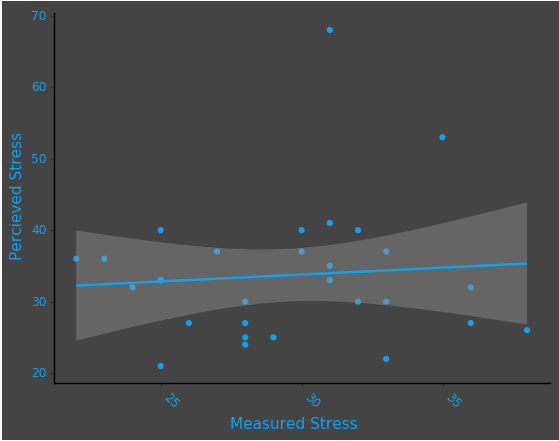

<ggplot: (8779305906785)>

coefficient of determination: 0.007064810587503079
b: 27.994648208933924
m: [0.19316398]
Ttest_relResult(statistic=-2.246011735758872, pvalue=0.03277786963357031)


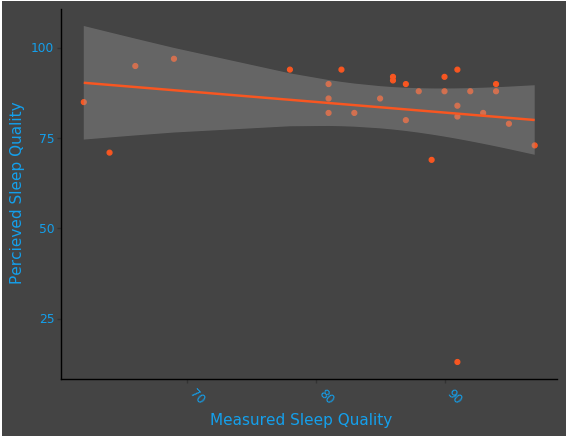

<ggplot: (8779306010421)>

coefficient of determination: 0.04088465813134479
b: 133.67049109083007
m: [-0.58144285]
Ttest_relResult(statistic=0.7992280830847192, pvalue=0.43088618089724284)


In [16]:
model = LinearRegression()

correlation_plots_stress = (p9.ggplot(data=total_data_with_percived)
                    + p9.geom_point(mapping=p9.aes(x='AVG_DAILY_STRESS_DERIVED', y='percieved_stress_level'), color='#14a0ec')
                    + p9.geom_smooth(mapping=p9.aes(x='AVG_DAILY_STRESS_DERIVED', y='percieved_stress_level'), color='#14a0ec', method='lm')
                    + p9.labs(x='Measured Stress', y='Percieved Stress')
                    + gourdotron_theme
                    + p9.theme(panel_grid_major=p9.element_line(color='#444444', alpha=.5), panel_grid_minor=p9.element_line(color='#444444', alpha=.5))
                    )

correlation_plots_sleep = (p9.ggplot(data=total_data_with_percived)
                    + p9.geom_point(mapping=p9.aes(x='overallScore', y='percieved_sleep_quality'), color='#F85621')
                    + p9.geom_smooth(mapping=p9.aes(x='overallScore', y='percieved_sleep_quality'), color='#F85621', method='lm')
                    + p9.labs(x='Measured Sleep Quality', y='Percieved Sleep Quality')
                    + gourdotron_theme
                    + p9.theme(panel_grid_major=p9.element_line(color='#444444', alpha=.5), panel_grid_minor=p9.element_line(color='#444444', alpha=.5))
                    )


correlation_plots_stress
m1 = model.fit(np.array((total_data_with_percived.AVG_DAILY_STRESS_DERIVED)).reshape(-1, 1), np.array(total_data_with_percived.percieved_stress_level))
r_sq = m1.score(np.array((total_data_with_percived.AVG_DAILY_STRESS_DERIVED)).reshape(-1, 1), total_data_with_percived.percieved_stress_level)
print('coefficient of determination:', r_sq)
print('b:', m1.intercept_)
print('m:', m1.coef_)
print(stats.ttest_rel(total_data_with_percived['AVG_DAILY_STRESS_DERIVED'], total_data_with_percived['percieved_stress_level']))


correlation_plots_sleep
m2 = model.fit(np.array((total_data_with_percived.overallScore)).reshape(-1, 1), np.array(total_data_with_percived.percieved_sleep_quality))
r_sq2 = m1.score(np.array((total_data_with_percived.overallScore)).reshape(-1, 1), total_data_with_percived.percieved_sleep_quality)
print('coefficient of determination:', r_sq2)
print('b:', m2.intercept_)
print('m:', m2.coef_)
print(stats.ttest_rel(total_data_with_percived['overallScore'], total_data_with_percived['percieved_sleep_quality']))
total_data_with_percived.to_csv('tester.csv')